None
tensor(-0.00427449, dtype=float32)
[0.00134095 0.00986604]


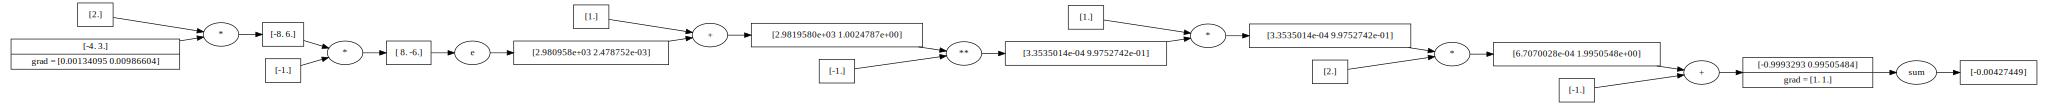

In [19]:
import numpy as np
from edunets.tensor import Tensor

a = Tensor([-4.0, 3.0], requires_grad=True)
b = a.tanh(); b.requires_grad = True

print(b)

z = b.sum()

print(z)

z.backward()

print(a.grad)  # dz/dx
z.graph

In [16]:
import torch

a = torch.tensor([-4.0, 3.0], requires_grad=True)
b = a.tanh()

print(b)

z = b.sum()

print(z)

z.backward()

print(a.grad)  # dz/dx

tensor([-0.9993,  0.9951], grad_fn=<TanhBackward>)
tensor(-0.0043, grad_fn=<SumBackward0>)
tensor([0.0013, 0.0099])


In [47]:
import torch

x = torch.tensor([[[0.5, 0.5, 0.5]], [[0.5, 0.5, 0.5]], [[0.5, 0.5, 0.5]]], requires_grad=True) # (2, 3)
y = torch.tensor([[[0.5], [0.6]]], requires_grad=True)
w = x + 2*y
w.retain_grad()
z = w.max()
z.backward()

print(20*'-')
print("x grad", x.grad)  # dz/dx
print("y grad", y.grad)  # dz/dy
print("w grad", w.grad) #
print(20*'-')
print(w*y)

--------------------
x grad tensor([[[0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111]]])
y grad tensor([[[0.],
         [2.]]])
w grad tensor([[[0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111]],

        [[0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111]],

        [[0.0000, 0.0000, 0.0000],
         [0.1111, 0.1111, 0.1111]]])
--------------------
tensor([[[0.7500, 0.7500, 0.7500],
         [1.0200, 1.0200, 1.0200]],

        [[0.7500, 0.7500, 0.7500],
         [1.0200, 1.0200, 1.0200]],

        [[0.7500, 0.7500, 0.7500],
         [1.0200, 1.0200, 1.0200]]], grad_fn=<MulBackward0>)


In [20]:
W = w.grad.numpy()
np.sum(W, axis=(0,1))

array([0.33333334, 0.33333334, 0.33333334], dtype=float32)

In [4]:
X = np.array([0.5, 1, 0.5])
Y = np.array([1, 0.5, 1])
X > Y

array([False,  True, False])